In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno

# 1. 데이터 불러오기

In [2]:
import os
path = os.getcwd()
file_list = os.listdir('./input')
file_list

['customers.csv',
 'articles.csv',
 'transactions_train.csv',
 'sample_submission.csv']

In [3]:
customers = pd.read_csv(path + '/input/' + 'customers.csv', encoding='UTF-8-sig')
articles = pd.read_csv(path + '/input/' + 'articles.csv', encoding='UTF-8-sig')
transactions_train = pd.read_csv(path + '/input/' + 'transactions_train.csv', encoding='UTF-8-sig')
sample_submission = pd.read_csv(path + '/input/' + 'sample_submission.csv', encoding='UTF-8-sig')

In [9]:
# 데이터베이스 생성
import psycopg2
from config import host, port, database,user, password
conn = psycopg2.connect(
    host = host,
    port = port,
    database = database,
    user = user,
    password = password
)
with conn.cursor() as curs:
    conn.autocommit = True
    sql = '''
        create database kaggle_hnm
    '''
    curs.execute(sql)
    


InsufficientPrivilege: permission denied to create database


# 2.결측값처리

## 2.1 customers
**특이사항**
- 'FN'과 'Active' 값에서 Null값 약 65%이상 발생

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [5]:
100 * (customers.isna().sum()/customers.shape[0])

customer_id                0.000000
FN                        65.237831
Active                    66.150819
club_member_status         0.441843
fashion_news_frequency     1.166854
age                        1.156066
postal_code                0.000000
dtype: float64

<AxesSubplot:>

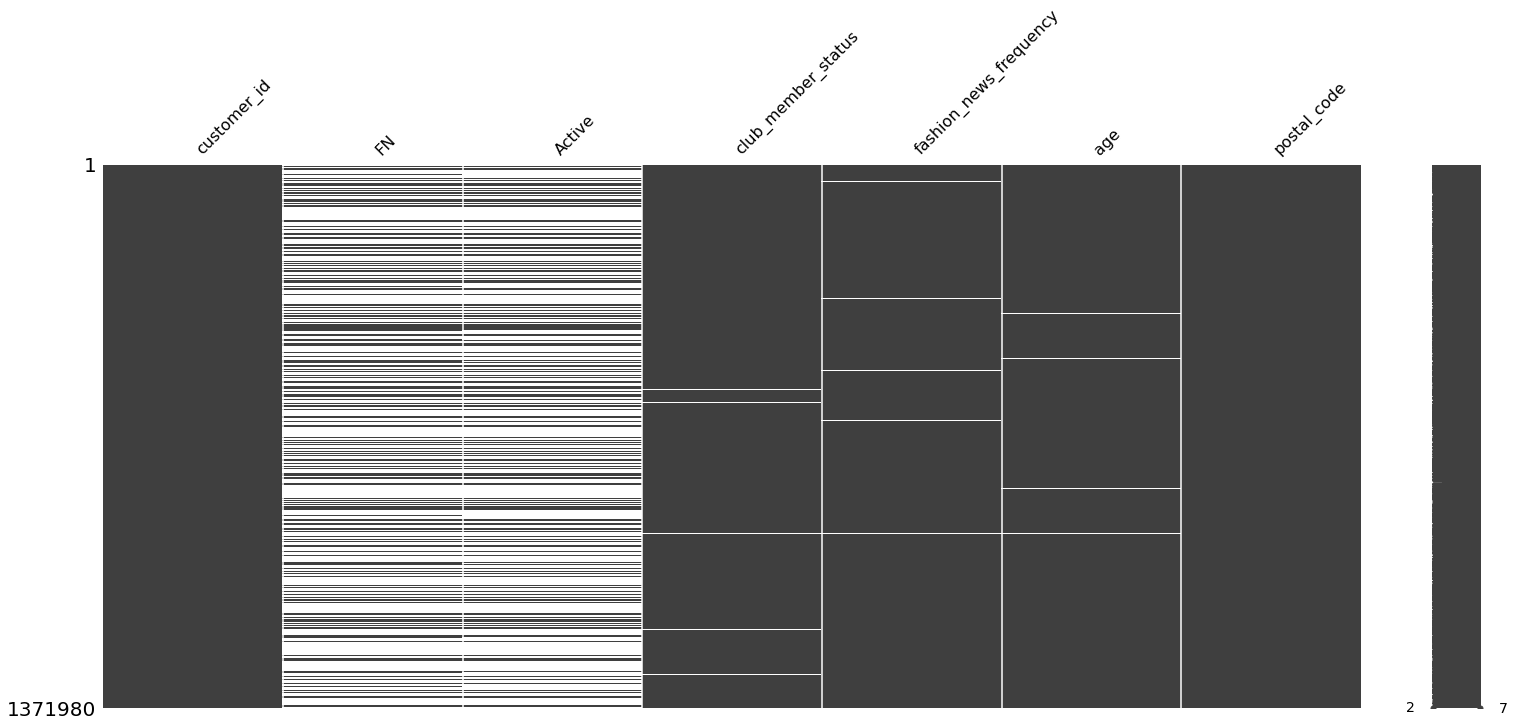

In [6]:
msno.matrix(customers)

### 2.1.1 FN & Active
- 결측값은 0으로 대체

In [7]:
FN_unique = customers['FN'].unique()
cust_unique = customers['Active'].unique()
print('"FN" & "Active" 데이터 탐구')
print('데이터 종류')
print(f'FN : {FN_unique}')
print(f'Active : {cust_unique}')

"FN" & "Active" 데이터 탐구
데이터 종류
FN : [nan  1.]
Active : [nan  1.]


In [8]:
customers['FN'] = customers['FN'].fillna(0)
customers['Active'] = customers['Active'].fillna(0)

### 2.1.2 club_member_status
결측값 = None으로 대체

In [9]:
customers['club_member_status'].unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

In [10]:
customers['club_member_status'] = customers['club_member_status'].fillna('None')

### 2.1.3 fashion_news_frequency
결측값 = None으로 대체

In [11]:
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', nan, 'Monthly', 'None'], dtype=object)

In [12]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')

### 2.1.4 age
datawig - Deep Neural Networks를 이용한 결측값 제거

출처: https://www.sigmoid.com/blogs/datawig-missing-value-imputation/#:~:text=Datawig%20is%20a%20Deep%20Learning,model%20and%20generate%20the%20predictions.

In [13]:
customers['age'].unique()

array([49., 25., 24., 54., 52., nan, 20., 32., 29., 31., 56., 75., 41.,
       27., 30., 48., 35., 22., 40., 38., 45., 68., 55., 19., 60., 44.,
       21., 26., 28., 53., 33., 17., 23., 51., 18., 34., 57., 47., 70.,
       50., 63., 58., 43., 67., 72., 42., 39., 79., 71., 59., 36., 62.,
       37., 46., 73., 64., 74., 61., 85., 69., 76., 66., 65., 82., 16.,
       90., 80., 78., 81., 84., 77., 97., 89., 83., 98., 88., 86., 87.,
       93., 91., 99., 96., 94., 92., 95.])

<AxesSubplot:xlabel='age', ylabel='Count'>

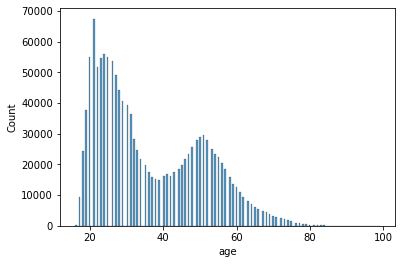

In [14]:
sns.histplot(customers['age'])

In [15]:
# %pip install datawig

<AxesSubplot:>

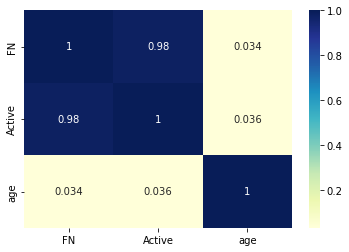

In [16]:
sns.heatmap(customers[['FN', 'Active','club_member_status','fashion_news_frequency','age']].corr(), cmap = 'YlGnBu', annot = True)

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fashion_news_frequency', ylabel='count'>

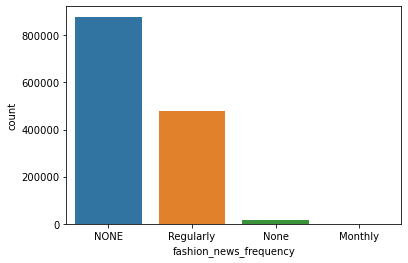

In [17]:
sns.countplot(customers['fashion_news_frequency'])

In [65]:
import datawig

df_train, df_test = datawig.utils.random_split(customers)

# SimpleImputer model 수행
imputer = datawig.SimpleImputer(
    input_columns = ['FN', 'Active'],
    output_column = 'age',
    output_path = 'imputer_model'
)

# Imputer model에 train data로 훈련시키기
imputer.fit(train_df = df_train, num_epochs = 50)

[20:49:19] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.
2022-06-13 20:49:19,755 [INFO]  
========== start: fit model
2022-06-13 20:49:19,760 [WARNING]  Already bound, ignoring bind()
2022-06-13 20:49:34,999 [INFO]  Epoch[0] Batch [0-30870]	Speed: 32648.59 samples/sec	cross-entropy=16.003459	age-accuracy=0.185158
2022-06-13 20:49:50,743 [INFO]  Epoch[0] Train-cross-entropy=16.000980
2022-06-13 20:49:50,747 [INFO]  Epoch[0] Train-age-accuracy=0.185947
2022-06-13 20:49:50,747 [INFO]  Epoch[0] Time cost=30.967
2022-06-13 20:49:50,757 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2022-06-13 20:49:53,325 [INFO]  Epoch[0] Validation-cross-entropy=16.358176
2022-06-13 20:49:53,327 [INFO]  Epoch[0] Validation-age-accuracy=0.000000
2022-06-13 20:50:09,783 [INFO]  Epoch[1] Batch [0-30870]	Speed: 30018.54 samples/sec	cross-entropy=15.981681	age-accuracy=0.185158
2022-06-13 20:50:24,789 [INFO]  Epoch[1] Train-cross-entropy=16.001635
2022-06-13 20:50:

: 

In [19]:
# 결측값 채우기
imputed = imputer.predict(customers[customers['age'].isna()])

AttributeError: 'Index' object has no attribute 'contains'

## 2.2 articles
**특이사항**
- 상품상세정보만 Null값 존재

<AxesSubplot:>

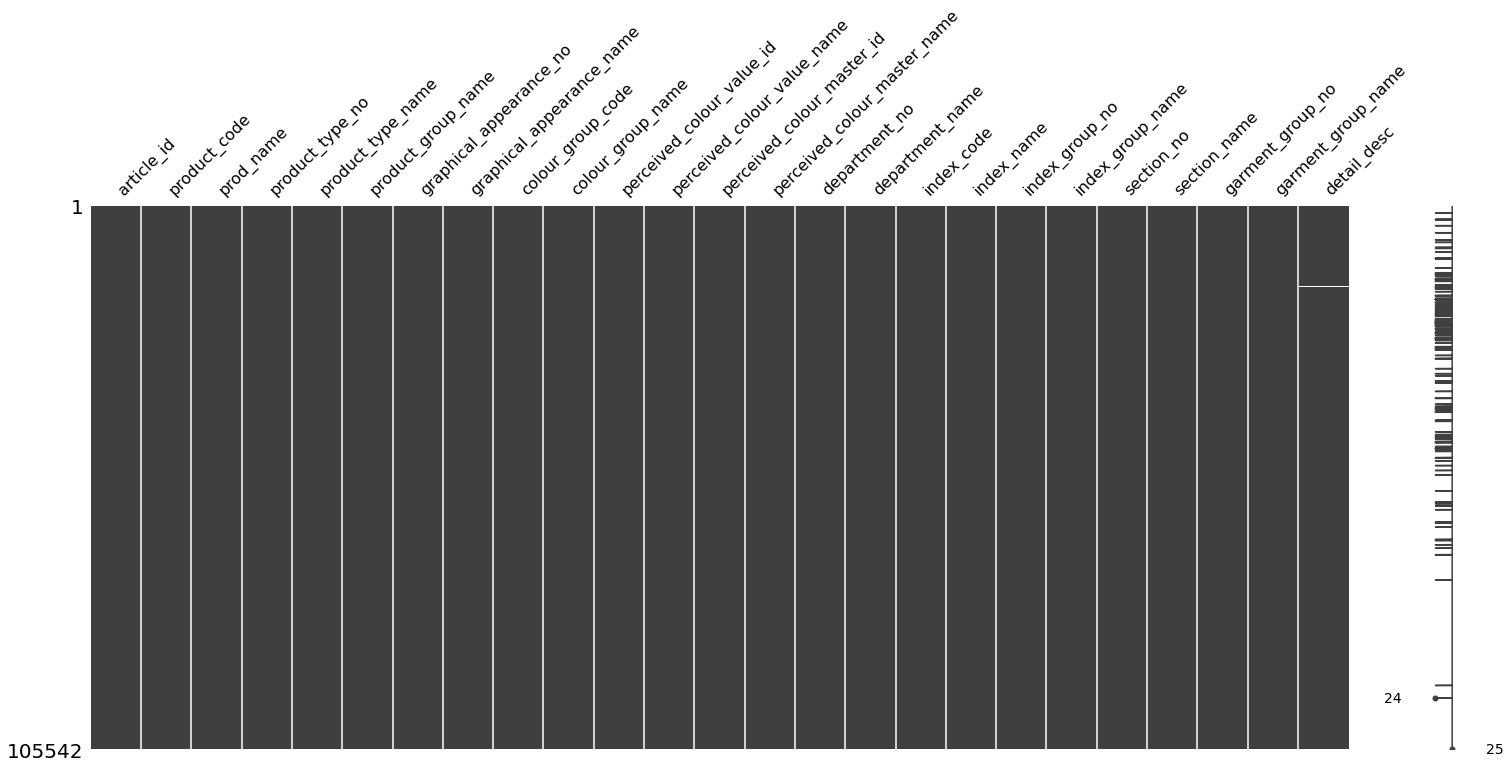

In [20]:
msno.matrix(articles)

In [21]:
100 * (articles.isna().sum()/articles.shape[0])

article_id                      0.000000
product_code                    0.000000
prod_name                       0.000000
product_type_no                 0.000000
product_type_name               0.000000
product_group_name              0.000000
graphical_appearance_no         0.000000
graphical_appearance_name       0.000000
colour_group_code               0.000000
colour_group_name               0.000000
perceived_colour_value_id       0.000000
perceived_colour_value_name     0.000000
perceived_colour_master_id      0.000000
perceived_colour_master_name    0.000000
department_no                   0.000000
department_name                 0.000000
index_code                      0.000000
index_name                      0.000000
index_group_no                  0.000000
index_group_name                0.000000
section_no                      0.000000
section_name                    0.000000
garment_group_no                0.000000
garment_group_name              0.000000
detail_desc     

In [22]:
articles.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


## 2.3 transaction

**특이사항**
- Null값 없음

In [23]:
transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [24]:
100 * (transactions_train.isna().sum()/transactions_train.shape[0])

t_dat               0.0
customer_id         0.0
article_id          0.0
price               0.0
sales_channel_id    0.0
dtype: float64

<AxesSubplot:>

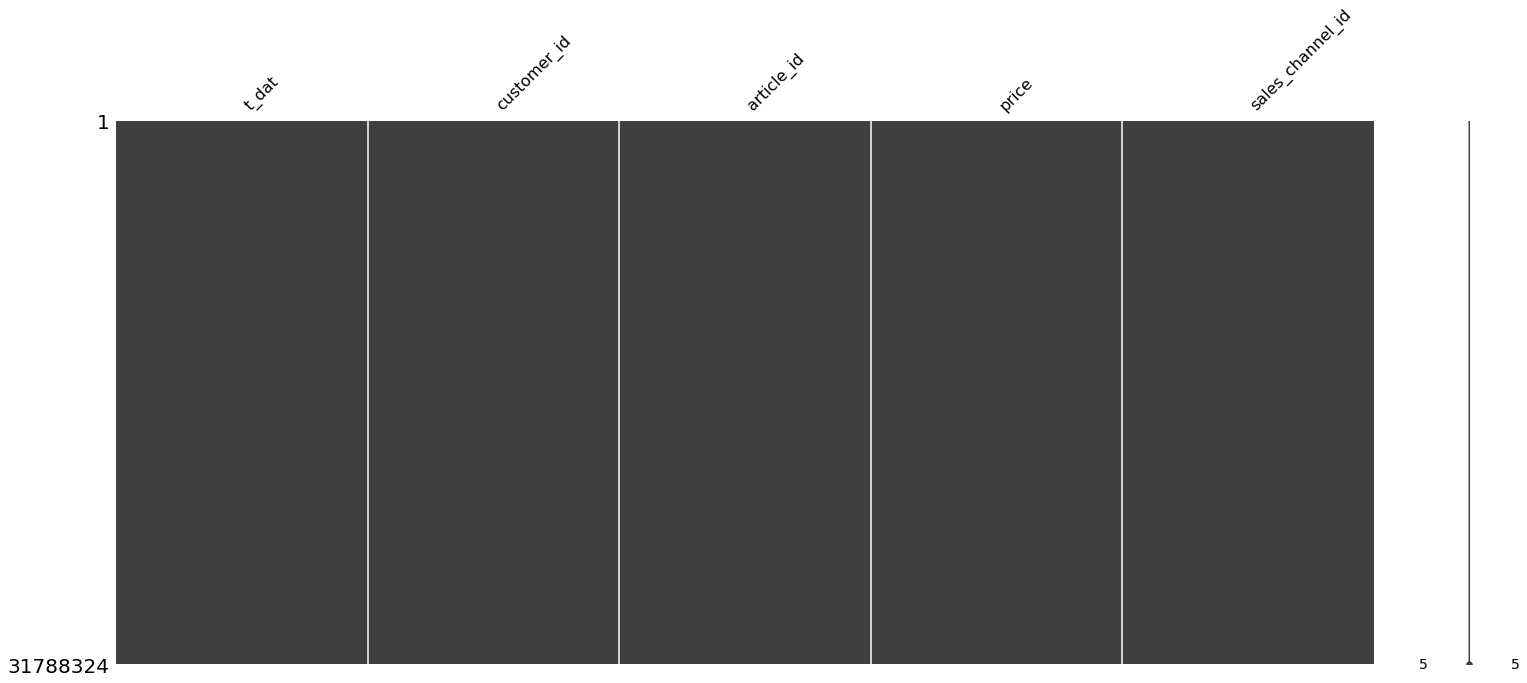

In [25]:
msno.matrix(transactions_train)

In [26]:
transactions_train.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2


# 3.EDA

- customers <-> transacionts_train : customer_id
- transactions_train <-> articles : article_id

In [17]:
customer_transation = pd.merge(customers, transactions_train, on = 'customer_id', how = 'inner')

In [18]:
transation_article = pd.merge(articles, transactions_train, on = 'article_id', how = 'inner')

In [ ]:
transation_article['t_dat'] = pd.to_datetime(transation_article['t_dat'])

In [19]:
merge_all = pd.merge(customer_transation, transation_article, on = ['customer_id', 'article_id'], how = 'inner')
merge_all.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,t_dat_x,article_id,price_x,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,t_dat_y,price_y,sales_channel_id_y
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,2018-12-27,625548001,0.044051,...,4,Baby/Children,45,Kids Outerwear,1007,Outdoor,"Padded jacket with a detachable hood, stand-up...",2018-12-27,0.044051,1
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,2018-12-27,176209023,0.035576,...,3,Menswear,31,Mens Outerwear,1007,Outdoor,"Short, padded jacket with a jersey-lined hood ...",2018-12-27,0.035576,1


# Questions
1. What type of product was sole the most top K
2. Which customers are defined as VIP
3. Does Membership work for selling
4. Does 

In [20]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [21]:
cat_mean_price = transation_article[['product_group_name','price']].groupby(by = ['product_group_name']).mean()
cat_mean_price = cat_mean_price.rename(columns = {'price':'mean_price'}).reset_index()

In [22]:
cat_min_price =  transation_article[['product_group_name','price']].groupby(by = ['product_group_name']).min()
cat_min_price = cat_min_price.rename(columns = {'price':'min_price'}).reset_index()

In [23]:
cat_max_price = transation_article[['product_group_name','price']].groupby(by = ['product_group_name']).max()
cat_max_price = cat_max_price.rename(columns = {'price':'max_price'}).reset_index()

In [24]:
cat_median_price = transation_article[['product_group_name','price']].groupby(by = ['product_group_name']).median()
cat_median_price = cat_median_price.rename(columns = {'price':'median_price'}).reset_index()

In [25]:
price_summary = pd.merge(cat_min_price, cat_mean_price, on = 'product_group_name', how = 'inner')
price_summary = pd.merge(price_summary, cat_median_price, on = 'product_group_name', how = 'inner')
price_summary = pd.merge(price_summary, cat_max_price, on = 'product_group_name', how = 'inner')
price_summary

,product_group_name,min_price,mean_price,median_price,max_price
0,Accessories,0.000034,0.015563,0.013542,0.337288
1,Bags,0.010153,0.033349,0.033881,0.067780
2,Cosmetic,0.000525,0.005848,0.005407,0.010153
3,Fun,0.008220,0.008885,0.008458,0.010831
4,Furniture,0.002169,0.009591,0.007102,0.050831
5,Garment Full body,0.000407,0.036166,0.033881,0.506780
6,Garment Lower body,0.000186,0.032894,0.033220,0.422034
7,Garment Upper body,0.000017,0.027005,0.022017,0.591525
8,Garment and Shoe care,0.002525,0.017484,0.014390,0.050831
9,Interior textile,0.007525,0.016449,0.013542,0.030492


<AxesSubplot:xlabel='price', ylabel='product_group_name'>

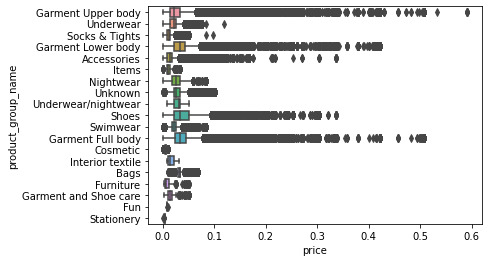

In [26]:
sns.boxplot(x = 'price', y = 'product_group_name', data = transation_article)

In [27]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [28]:
articles.head(1)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


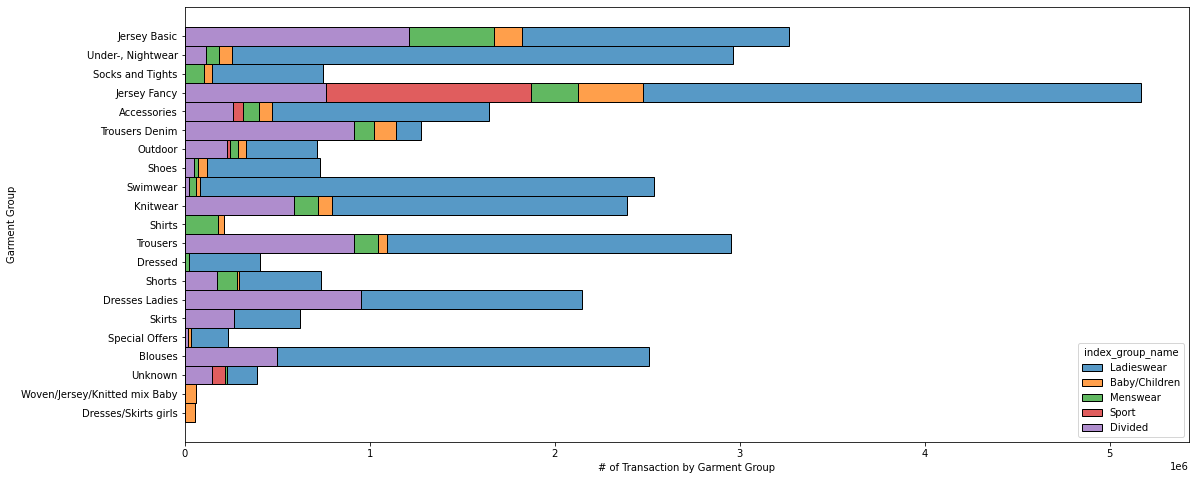

In [29]:
# Best Sellers
fig, ax = plt.subplots(figsize = (18,8))
ax = sns.histplot(y = 'garment_group_name', data = transation_article, hue = 'index_group_name', multiple = 'stack')
ax.set_ylabel('Garment Group')
ax.set_xlabel('# of Transaction by Garment Group')
plt.show()

In [30]:

transaction_index_group_name = transation_article.groupby(['garment_group_name', 'index_group_name']).count()['article_id'].reset_index()
transaction_index_group_name = transaction_index_group_name.rename(columns = {'article_id':'transaction_index_group_name'})


count_index_group_name = articles.groupby(['garment_group_name', 'index_group_name']).count()['article_id'].reset_index()
count_index_group_name = count_index_group_name.rename(columns = {'article_id':'count_index_group_name'})


In [31]:

transaction_index_group_name = transation_article.groupby(['garment_group_name', 'index_group_name']).count()['article_id'].reset_index()
transaction_index_group_name = transaction_index_group_name.rename(columns = {'article_id':'transaction_index_group_name'})
transaction_index_group_name

,garment_group_name,index_group_name,transaction_index_group_name
0,Accessories,Baby/Children,73535
1,Accessories,Divided,261463
2,Accessories,Ladieswear,1171487
3,Accessories,Menswear,83355
4,Accessories,Sport,55624
...,...,...,...
67,Unknown,Divided,149661
68,Unknown,Ladieswear,162978
69,Unknown,Menswear,10678
70,Unknown,Sport,68050


In [32]:
count_index_group_name = articles.groupby(['garment_group_name', 'index_group_name']).count()['article_id'].reset_index()
count_index_group_name = count_index_group_name.rename(columns = {'article_id':'count_index_group_name'})
count_index_group_name

,garment_group_name,index_group_name,count_index_group_name
0,Accessories,Baby/Children,3293
1,Accessories,Divided,1458
2,Accessories,Ladieswear,4999
3,Accessories,Menswear,1388
4,Accessories,Sport,381
...,...,...,...
67,Unknown,Divided,748
68,Unknown,Ladieswear,1789
69,Unknown,Menswear,489
70,Unknown,Sport,788


In [33]:

# Merging data
merged_index_group_summary = pd.merge(transaction_index_group_name, count_index_group_name, on = ['garment_group_name', 'index_group_name'], how = 'inner')

# Get the Popular index_group 
"""
popularity = transation index group 별 총 거래횟수 / index group 갯수
"""
merged_index_group_summary['popularity'] = merged_index_group_summary['transaction_index_group_name'] / merged_index_group_summary['count_index_group_name']
merged_index_group_summary = merged_index_group_summary.sort_values(by = 'popularity', ascending=False)
merged_index_group_summary

,garment_group_name,index_group_name,transaction_index_group_name,count_index_group_name,popularity
51,Swimwear,Ladieswear,2455138,1839,1335.039695
14,Jersey Basic,Ladieswear,1442636,1359,1061.542311
59,Trousers Denim,Divided,916352,879,1042.493743
38,Shorts,Ladieswear,441660,429,1029.510490
43,Socks and Tights,Ladieswear,601458,651,923.898618
...,...,...,...,...,...
0,Accessories,Baby/Children,73535,3293,22.330701
69,Unknown,Menswear,10678,489,21.836401
32,Shoes,Baby/Children,47762,2197,21.739645
57,Trousers,Sport,5,1,5.000000


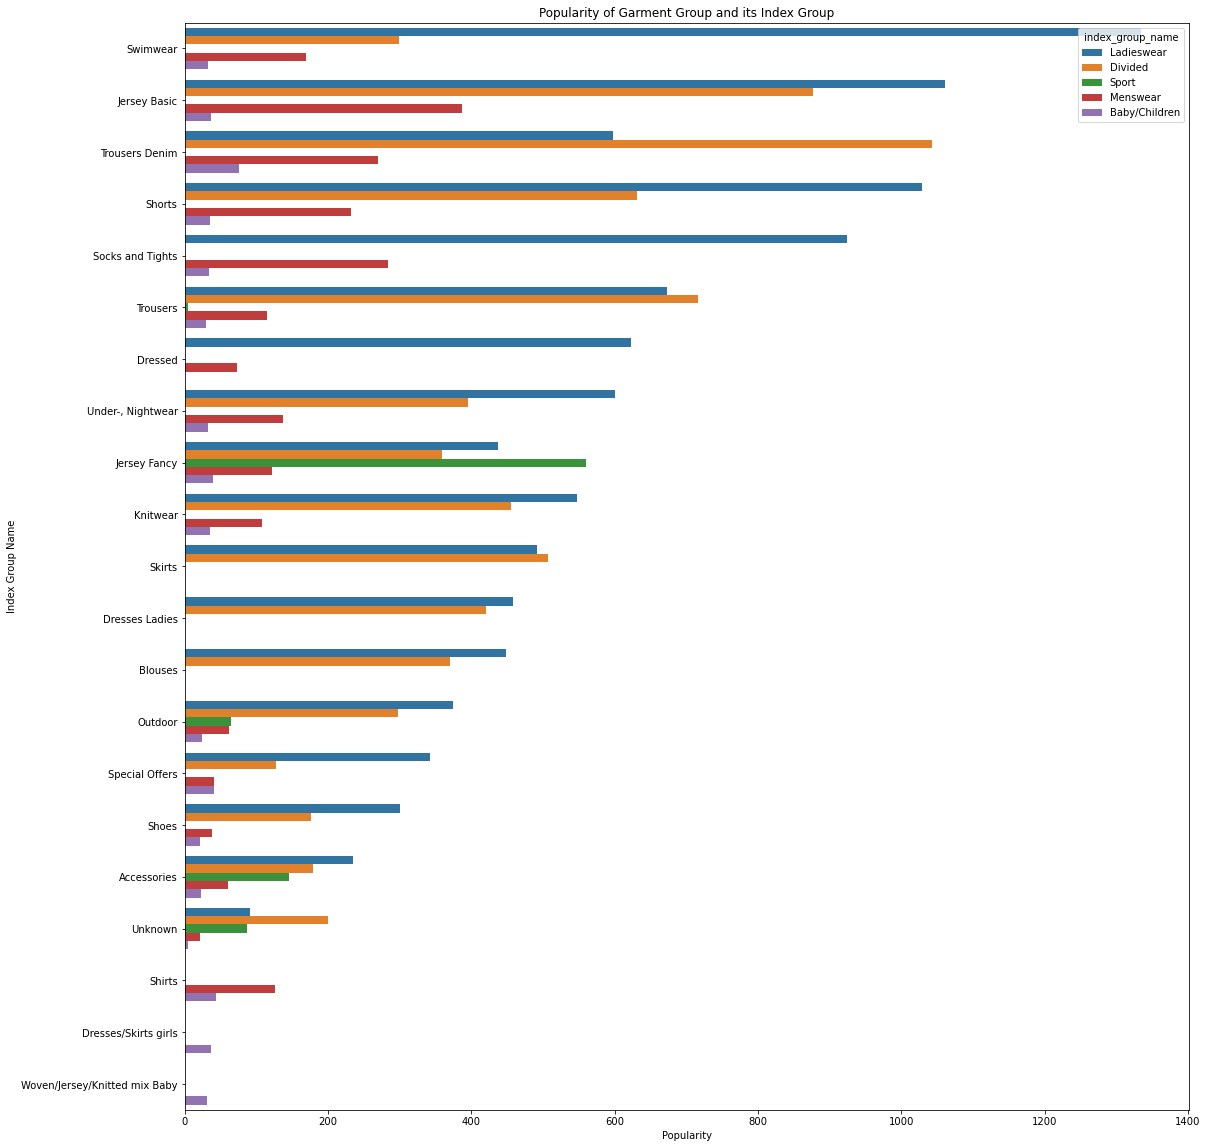

In [44]:
fig, ax = plt.subplots(figsize = (18,20))
ax = sns.barplot(data = merged_index_group_summary, y = 'garment_group_name', x = 'popularity', hue = 'index_group_name')
ax.set_xlabel('Popularity')
ax.set_ylabel('Index Group Name')
plt.title('Popularity of Garment Group and its Index Group')
plt.show()

In [45]:
transactions_train.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [58]:
transation_article.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,t_dat,customer_id,price,sales_channel_id
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,0.008458,1
1,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,0.008458,1
2,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,0aaa9683d5f45b85d0f9a81e2f4d4ef774fed43339fb75...,0.008068,2


In [60]:
transation_article.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,t_dat,customer_id,price,sales_channel_id
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,0.008458,1
1,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,0.008458,1
2,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,2018-09-20,0aaa9683d5f45b85d0f9a81e2f4d4ef774fed43339fb75...,0.008068,2


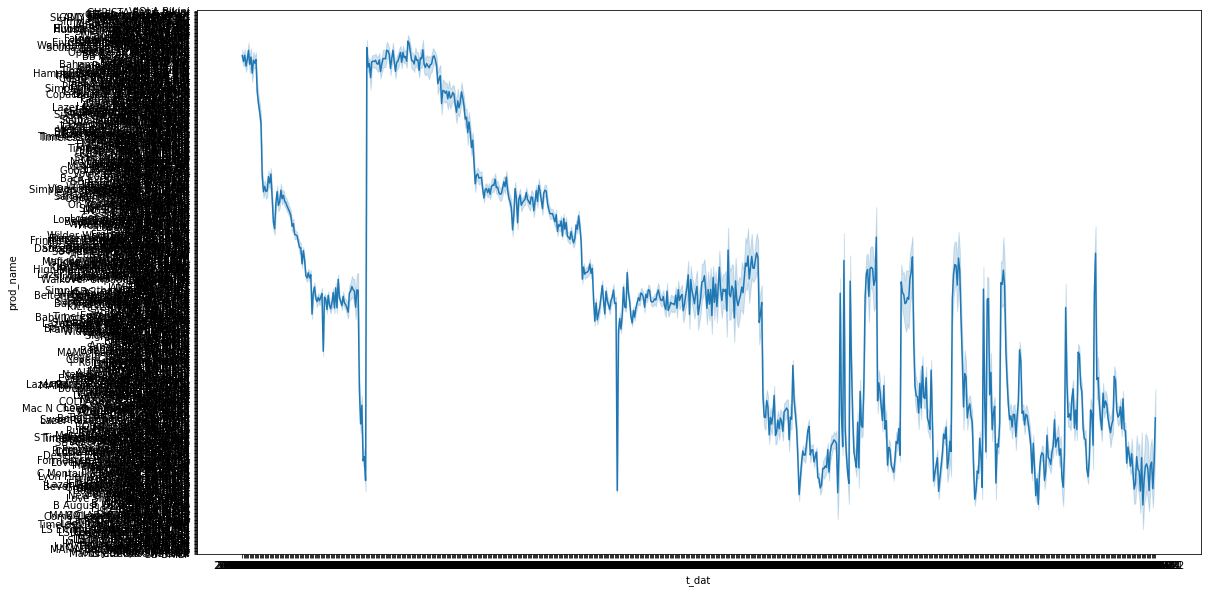

In [61]:
fig, ax = plt.subplots(figsize = (18,10))
ax = sns.lineplot(data = transation_article[transation_article['garment_group_name']=='Swimwear'], x = 't_dat', y = 'prod_name')
plt.show()

In [64]:
transation_article['t_dat'] = pd.to_datetime(transation_article['t_dat'])

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

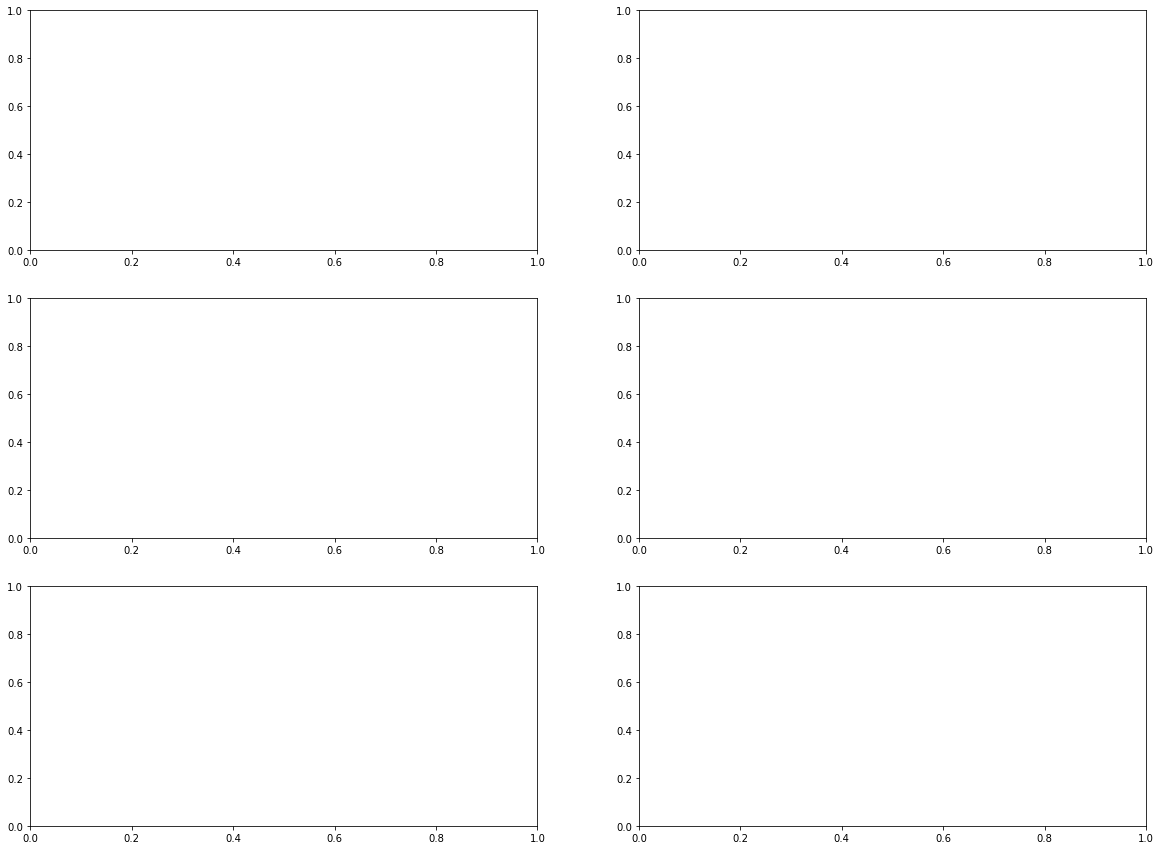

In [62]:
product_list = ['Shoes', 'Garment Full body', 'Bags', 'Garment Lower body', 'Underwear/nightwear']
colors = ['cadetblue', 'orange', 'mediumspringgreen', 'tomato', 'lightseagreen']

k = 0
f, ax = plt.subplots(3, 2, figsize=(20, 15))
for i in range(3):
    for j in range(2):
        try:
            product = product_list[k]
            articles_for_merge_product = transation_article[transation_article.product_group_name == product_list[k]]
            series_mean = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).mean().fillna(0)
            series_std = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).std().fillna(0)
            ax[i, j].plot(series_mean, linewidth=4, color=colors[k])
            ax[i, j].fill_between(series_mean.index, (series_mean.values-2*series_std.values).ravel(), 
                             (series_mean.values+2*series_std.values).ravel(), color=colors[k], alpha=.1)
            ax[i, j].set_title(f'Mean {product_list[k]} price in time')
            ax[i, j].set_xlabel('month')
            ax[i, j].set_xlabel(f'{product_list[k]}')
            k += 1
        except IndexError:
            ax[i, j].set_visible(False)
plt.show()